# gpt2_basic_training
## 2025DEC08


## 1. package loading

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
import tiktoken
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
import json
from copy import deepcopy


## 2. setup paths for llm package load

In [2]:

PROJECT_ROOT = Path().resolve().parents[0]          # -> .../project_root
SRC_DIR = PROJECT_ROOT / "src"           # -> .../project_root/src
print(SRC_DIR)

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from llm_from_scratch.configs import gpt2small_config
from llm_from_scratch.training import training_utils
from llm_from_scratch.models import gpt2
from llm_from_scratch.dataloader import dataloader

/home/markb/llm-from-scratch/src


## 3. setup run_training()

In [3]:
def run_training(cfg):
    """Run a single training experiment given a config dict."""
    cfg = deepcopy(cfg)  # avoid in-place mutation

    model_cfg = cfg['model_config']
    device = cfg['device_name']
    torch.manual_seed(cfg['seed'])
    print(cfg)
    # modify cfg)
    # setup model
    model = gpt2.setup_model(model_cfg)
    totparams = sum(p.numel() for p in model.parameters())
    print("Total number of parameters:", totparams)

    # DEBUG: check model
    print("weight_tying flag:", model_cfg["weight_tying"])
    print("same object?:", model.out_head.weight is model.tok_emb.weight)
    print("out_head.weight shape:", model.out_head.weight.shape)
    print("tok_emb.weight shape:", model.tok_emb.weight.shape)


    # tokenizer
    tokenizer = tiktoken.get_encoding(cfg['tokenizer'])

    # dataloaders
    train_loader, val_loader, test_loader = dataloader.generate_data_loaders(cfg)
    print("Show train_loader first entry (converted to text):")
    dataloader.loader_text_examine(train_loader, 0, tokenizer)
    print("Show val_loader first entry (converted to text):")
    dataloader.loader_text_examine(val_loader, 0, tokenizer)
    if test_loader is not None:
        print("Show test_loader first entry (converted to text):")
        dataloader.loader_text_examine(test_loader, 0, tokenizer)
    
    # DEBUG: check
    # get one batch
    input_batch, target_batch = next(iter(train_loader))
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    with torch.no_grad():
        logits = model(input_batch)

    print("tok_emb weight: mean, std:",
        model.tok_emb.weight.mean().item(),
        model.tok_emb.weight.std().item())
    print("out_head weight: mean, std:",
        model.out_head.weight.mean().item(),
        model.out_head.weight.std().item())

    print("embeds std:", model.tok_emb(input_batch).std().item())
    print("logits: mean, std, min, max:",
        logits.mean().item(),
        logits.std().item(),
        logits.min().item(),
        logits.max().item())


    # training loop
    num_epochs = cfg['num_epochs']
    optimizer = training_utils.setup_optimizer(model, cfg)
    train_losses, val_losses, tokens_seen, global_step = training_utils.train_model_simple(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=cfg['device_name'],
        num_epochs=cfg['num_epochs'],
        eval_freq=5,
        eval_iter=5,
        start_context="Every effort moves you",
        tokenizer=tokenizer
    )

    # plot and save plot
    epochs_tensor = torch.linspace(0, cfg['num_epochs'], len(train_losses))
    training_utils.plot_losses(cfg, epochs_tensor, tokens_seen, train_losses, val_losses)

    # save cfg and checkpoint
    training_utils.save_cfg_json(
        cfg=cfg, 
        epoch=num_epochs, 
        global_step=global_step)  
    training_utils.save_checkpoint(
        model=model,
        optimizer=optimizer,
        cfg=cfg,
        epoch=cfg['num_epochs'],
        global_step=global_step,
    )
    training_utils.save_results(cfg,
        train_losses, val_losses, tokens_seen, global_step)
    

    # return some results
    return {
        "final_train_loss": float(train_losses[-1]),
        "final_val_loss": float(val_losses[-1]),
        "tokens_seen": int(tokens_seen[-1]),
        "global_step": int(global_step),
    }



## 4. EXPERIMENT 1: basic params

### configs

In [4]:
cfg = gpt2small_config.RUN_CONFIG
cfg
cfg2 = deepcopy(cfg)
cfg2['run_name'] = "gpt2_check_1"

### run model

In [5]:
#run_training(cfg2)

## Experiment 1a: make sure that model really resets

In [6]:
#cfg2['run_name']="gpt2_check_2"
#run_training(cfg2)

## Experiment 2: change stride to do more training

In [7]:
cfg2['run_name']="gpt2_notebook_test_stridechange"
cfg2['stride']=128
cfg2

{'run_name': 'gpt2_notebook_test_stridechange',
 'description': 'gpt2-small on the verdict',
 'device_name': 'cpu',
 'model_name': 'gpt2-small',
 'model_config': {'vocab_size': 50257,
  'context_length': 256,
  'emb_dim': 768,
  'n_heads': 12,
  'n_layers': 12,
  'drop_rate': 0.1,
  'qkv_bias': False,
  'weight_tying': False},
 'tokenizer': 'gpt2',
 'pretrained': False,
 'training_file': '/home/markb/llm-from-scratch/data/the-verdict.txt',
 'val_file': '',
 'test_file': '',
 'val_ratio': 0.1,
 'test_ratio': 0.0,
 'stride': 128,
 'batch_size': 2,
 'lr': 0.0004,
 'weight_decay': 0.15,
 'num_epochs': 2,
 'seed': 42,
 'output_dir': '/home/markb/llm-from-scratch/output'}

### run model

{'run_name': 'gpt2_notebook_test_stridechange', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/the-verdict.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.15, 'num_epochs': 2, 'seed': 42, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 162419712
weight_tying flag: False
same object?: False
out_head.weight shape: torch.Size([50257, 768])
tok_emb.weight shape: torch.Size([50257, 768])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/the-verdict.txt
Characters: 20479
Tokens: 5145


Show train_loader first entry (converted to text):
I HA

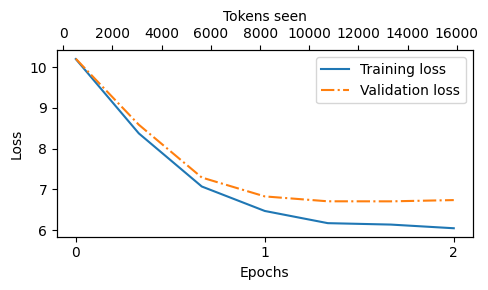

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_notebook_test_stridechange/epoch002_step0000033_cfg.json
Saved checkpoint to /home/markb/llm-from-scratch/output/gpt2_notebook_test_stridechange/epoch002_step0000033.pth
Saved results to /home/markb/llm-from-scratch/output/gpt2_notebook_test_stridechange/epoch002_step0000033_results.json


{'final_train_loss': 6.044402599334717,
 'final_val_loss': 6.736466884613037,
 'tokens_seen': 15872,
 'global_step': 33}

In [8]:
run_training(cfg2)

## Experiment 3: try to do the weight-tying

In [9]:
cfg2['run_name']="gpt2_notebook_stride_weight_tying"
cfg2['model_config']['weight_tying']=True
cfg2

{'run_name': 'gpt2_notebook_stride_weight_tying',
 'description': 'gpt2-small on the verdict',
 'device_name': 'cpu',
 'model_name': 'gpt2-small',
 'model_config': {'vocab_size': 50257,
  'context_length': 256,
  'emb_dim': 768,
  'n_heads': 12,
  'n_layers': 12,
  'drop_rate': 0.1,
  'qkv_bias': False,
  'weight_tying': True},
 'tokenizer': 'gpt2',
 'pretrained': False,
 'training_file': '/home/markb/llm-from-scratch/data/the-verdict.txt',
 'val_file': '',
 'test_file': '',
 'val_ratio': 0.1,
 'test_ratio': 0.0,
 'stride': 128,
 'batch_size': 2,
 'lr': 0.0004,
 'weight_decay': 0.15,
 'num_epochs': 2,
 'seed': 42,
 'output_dir': '/home/markb/llm-from-scratch/output'}

{'run_name': 'gpt2_notebook_stride_weight_tying', 'description': 'gpt2-small on the verdict', 'device_name': 'cpu', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': True}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/home/markb/llm-from-scratch/data/the-verdict.txt', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 128, 'batch_size': 2, 'lr': 0.0004, 'weight_decay': 0.15, 'num_epochs': 2, 'seed': 42, 'output_dir': '/home/markb/llm-from-scratch/output'}
Total number of parameters: 123822336
weight_tying flag: True
same object?: True
out_head.weight shape: torch.Size([50257, 768])
tok_emb.weight shape: torch.Size([50257, 768])
check_flag is True; output of train_file
/home/markb/llm-from-scratch/data/the-verdict.txt
Characters: 20479
Tokens: 5145


Show train_loader first entry (converted to text):
I HAD

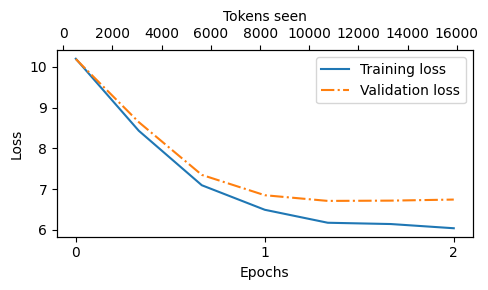

Saved cfg to /home/markb/llm-from-scratch/output/gpt2_notebook_stride_weight_tying/epoch002_step0000033_cfg.json
Saved checkpoint to /home/markb/llm-from-scratch/output/gpt2_notebook_stride_weight_tying/epoch002_step0000033.pth
Saved results to /home/markb/llm-from-scratch/output/gpt2_notebook_stride_weight_tying/epoch002_step0000033_results.json


{'final_train_loss': 6.039965629577637,
 'final_val_loss': 6.744129180908203,
 'tokens_seen': 15872,
 'global_step': 33}

In [10]:
run_training(cfg2)